# **QUESTION 1**

## **DATASET LOADING**

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.datasets import make_classification


# # Load the PIMA Indians diabetes dataset
url = "data/PIMA_indians_diabetes.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

# # Load the dataset into a DataFrame
data = pd.read_csv(url, names=columns)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## **PREPROCESSING**

In [4]:
# Replace zero values with NaN for relevant columns
# data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

# Impute missing values using the median
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Define the function to replace outliers with the median
def replace_outliers_with_median(err_arr):
    a = err_arr
    med = np.median(a)
    outlierConstant = 1.5
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    # Find the outliers within 75% interval and replace them with median value
    output = np.where((a >= quartileSet[0]) & (a <= quartileSet[1]), a, med)
    return output

# Apply the outlier replacement with median on relevant features
for column in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']:
    data_imputed[column] = replace_outliers_with_median(data_imputed[column])

# Log transform skewed features (optional)
# for column in ['Insulin', 'SkinThickness', 'BMI']:
#     data_imputed[column] = np.log1p(data_imputed[column])

# Standardize the feature set
scaler = StandardScaler()
X = data_imputed.drop('Outcome', axis=1)
X_scaled = scaler.fit_transform(X)

# Outcome (target)
y = data_imputed['Outcome']

# Apply SMOTE to the entire dataset before splitting
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (70% training, 30% testing)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# # Split into training and testing sets (70% training, 30% testing) before resampling
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# # Apply SMOTE only to the training set to handle class imbalance
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## **HYPERPARAMETER TUNING**

### **DECISION TREE CLASSIFIER**

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Create the model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter space without 'auto'
param_dist_dt = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'splitter': ['best', 'random'],  # Strategy used to split at each node
    'max_depth': np.arange(3, 20),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 10),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Valid options for the number of features to consider for the best split
}

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform the random search as before
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=50, scoring=scoring, refit='accuracy', cv=5, random_state=42, n_jobs=-1)

# Fit the model
random_search_dt.fit(X_resampled, y_resampled)

# Extract and sort the results by accuracy
results_dt = sorted(
    zip(
        random_search_dt.cv_results_['params'],
        random_search_dt.cv_results_['mean_test_accuracy'],
        random_search_dt.cv_results_['mean_test_precision'],
        random_search_dt.cv_results_['mean_test_recall'],
        random_search_dt.cv_results_['mean_test_f1']
    ),
    key=lambda x: x[1]  # Sort by accuracy (index 1 in the tuple)
)

# Print the results as before
print("Decision Tree: Hyperparameter combinations and corresponding metrics (ordered by accuracy):")
for i, (params, accuracy, precision, recall, f1) in enumerate(results_dt):
    print(f"Case {i + 1}: {params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}\n")

# Print the best combination of hyperparameters and its score
print("\nBest Decision Tree hyperparameters:")
print(random_search_dt.best_params_)
print(f"Best accuracy: {random_search_dt.best_score_:.4f}")


Decision Tree: Hyperparameter combinations and corresponding metrics (ordered by accuracy):
Case 1: {'splitter': 'random', 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'entropy'}
Accuracy: 0.5890
Precision: 0.6114
Recall: 0.5890
F1-score: 0.5719

Case 2: {'splitter': 'random', 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini'}
Accuracy: 0.5990
Precision: 0.6083
Recall: 0.5990
F1-score: 0.5898

Case 3: {'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini'}
Accuracy: 0.6150
Precision: 0.6440
Recall: 0.6150
F1-score: 0.5941

Case 4: {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'gini'}
Accuracy: 0.6160
Precision: 0.6271
Recall: 0.6160
F1-score: 0.6083

Case 5: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf':

### **RANDOM FOREST CLASSIFIER**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Create the model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter space
param_dist = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 10),  # Minimum number of samples required to split a node
    'min_samples_leaf': np.arange(1, 5),  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Updated to remove 'auto'
    'bootstrap': [True, False]  # Whether to bootstrap samples when building trees
}

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Randomized search with 50 different combinations of hyperparameters
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1,
    error_score='raise'  # Optional: set to 'raise' to debug further issues
)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)  # Ensure X_resampled and y_resampled are defined

# Extract and sort the results by accuracy
results = sorted(
    zip(
        random_search.cv_results_['params'],
        random_search.cv_results_['mean_test_accuracy'],
        random_search.cv_results_['mean_test_precision'],
        random_search.cv_results_['mean_test_recall'],
        random_search.cv_results_['mean_test_f1']
    ),
    key=lambda x: x[1],  # Sort by accuracy (index 1 in the tuple)
    reverse=True  # Optional: Sort in descending order for highest accuracy first
)

# Print out the hyperparameters and corresponding metrics for each case, ordered by accuracy
print("Hyperparameter combinations and corresponding metrics (ordered by accuracy):")
for i, (params, accuracy, precision, recall, f1) in enumerate(results):
    print(f"Case {i + 1}: {params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}\n")

# Print the best combination of hyperparameters and its score
print("\nBest hyperparameters:")
print(random_search.best_params_)
print(f"Best accuracy: {random_search.best_score_:.4f}")

Hyperparameter combinations and corresponding metrics (ordered by accuracy):
Case 1: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
Accuracy: 0.8340
Precision: 0.8375
Recall: 0.8340
F1-score: 0.8337

Case 2: {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Accuracy: 0.8340
Precision: 0.8381
Recall: 0.8340
F1-score: 0.8337

Case 3: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Accuracy: 0.8330
Precision: 0.8364
Recall: 0.8330
F1-score: 0.8327

Case 4: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Accuracy: 0.8300
Precision: 0.8333
Recall: 0.8300
F1-score: 0.8297

Case 5: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2',

In [7]:
# SUPPORT VECTOR MACHINE

### **SUPPORT VECTOR MACHINE**

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Create the model
svm_model = SVC(random_state=42)

# Define the hyperparameter space
param_dist = {
    'C': np.logspace(-3, 2, 6),  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel types
    'degree': np.arange(2, 5),  # Degree for 'poly' kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'coef0': [0.0, 0.1, 0.5],  # Independent term in kernel function for 'poly' and 'sigmoid'
}

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Randomized search with 100 different combinations of hyperparameters
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=20, scoring=scoring, refit='accuracy', cv=5, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)  # Assuming X_train_resampled, y_train_resampled are your training data

# Extract and sort the results by accuracy
results = sorted(
    zip(
        random_search.cv_results_['params'],
        random_search.cv_results_['mean_test_accuracy'],
        random_search.cv_results_['mean_test_precision'],
        random_search.cv_results_['mean_test_recall'],
        random_search.cv_results_['mean_test_f1']
    ),
    key=lambda x: x[1]  # Sort by accuracy (index 1 in the tuple)
)

# Print out the hyperparameters and corresponding metrics for each case, ordered by accuracy
print("Hyperparameter combinations and corresponding metrics (ordered by accuracy):")
for i, (params, accuracy, precision, recall, f1) in enumerate(results):
    print(f"Case {i + 1}: {params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}\n")

# Print the best combination of hyperparameters and its score
print("\nBest hyperparameters:")
print(random_search.best_params_)
print(f"Best accuracy: {random_search.best_score_:.4f}")


Hyperparameter combinations and corresponding metrics (ordered by accuracy):
Case 1: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 0.001}
Accuracy: 0.5290
Precision: 0.7007
Recall: 0.5290
F1-score: 0.4003

Case 2: {'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 3, 'coef0': 0.5, 'C': 1.0}
Accuracy: 0.6370
Precision: 0.6379
Recall: 0.6370
F1-score: 0.6364

Case 3: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 0.1}
Accuracy: 0.7020
Precision: 0.7321
Recall: 0.7020
F1-score: 0.6918

Case 4: {'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 2, 'coef0': 0.5, 'C': 0.1}
Accuracy: 0.7160
Precision: 0.7168
Recall: 0.7160
F1-score: 0.7158

Case 5: {'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 3, 'coef0': 0.1, 'C': 0.001}
Accuracy: 0.7180
Precision: 0.7184
Recall: 0.7180
F1-score: 0.7179

Case 6: {'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 2, 'coef0': 0.5, 'C': 0.1}
Accuracy: 0.7190
Precision: 0.7199
Recall: 0.7190
F1-score: 0.7187

Case 7: {

### **STACKING ENSEMBLE**

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the base estimators
estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(random_state=42, probability=True))
]

# Define the stacking model with Logistic Regression as the final estimator
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

# Define the hyperparameter space for RandomizedSearchCV
param_dist = {
    'final_estimator__C': np.logspace(-3, 2, 6),  # Regularization parameter for LogisticRegression
    'rf__n_estimators': [50, 100, 200],  # Number of trees for RandomForest
    'rf__max_depth': [10, 20, 30],  # Max depth of trees for RandomForest
    'svm__C': np.logspace(-3, 2, 6),  # Regularization parameter for SVC
    'dt__max_depth': [None, 10, 20, 30],  # Max depth for DecisionTree
}

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Randomized search with 20 different combinations of hyperparameters
random_search = RandomizedSearchCV(stacking_model, param_distributions=param_dist, n_iter=10, scoring=scoring, refit='accuracy', cv=5, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)  # Assuming X_resampled and y_resampled are your training data

# Extract and sort the results by accuracy
results = sorted(
    zip(
        random_search.cv_results_['params'],
        random_search.cv_results_['mean_test_accuracy'],
        random_search.cv_results_['mean_test_precision'],
        random_search.cv_results_['mean_test_recall'],
        random_search.cv_results_['mean_test_f1']
    ),
    key=lambda x: x[1]  # Sort by accuracy (index 1 in the tuple)
)

# Print out the hyperparameters and corresponding metrics for each case, ordered by accuracy
print("Hyperparameter combinations and corresponding metrics (ordered by accuracy):")
for i, (params, accuracy, precision, recall, f1) in enumerate(results):
    print(f"Case {i + 1}: {params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}\n")

# Print the best combination of hyperparameters and its score
print("\nBest hyperparameters:")
print(random_search.best_params_)
print(f"Best accuracy: {random_search.best_score_:.4f}")


Hyperparameter combinations and corresponding metrics (ordered by accuracy):
Case 1: {'svm__C': 0.001, 'rf__n_estimators': 100, 'rf__max_depth': 10, 'final_estimator__C': 0.001, 'dt__max_depth': 10}
Accuracy: 0.7560
Precision: 0.7603
Recall: 0.7560
F1-score: 0.7552

Case 2: {'svm__C': 0.001, 'rf__n_estimators': 50, 'rf__max_depth': 20, 'final_estimator__C': 0.01, 'dt__max_depth': 30}
Accuracy: 0.7610
Precision: 0.7650
Recall: 0.7610
F1-score: 0.7603

Case 3: {'svm__C': 0.01, 'rf__n_estimators': 200, 'rf__max_depth': 10, 'final_estimator__C': 0.1, 'dt__max_depth': None}
Accuracy: 0.7980
Precision: 0.8020
Recall: 0.7980
F1-score: 0.7976

Case 4: {'svm__C': 0.1, 'rf__n_estimators': 200, 'rf__max_depth': 30, 'final_estimator__C': 0.1, 'dt__max_depth': 30}
Accuracy: 0.8030
Precision: 0.8066
Recall: 0.8030
F1-score: 0.8027

Case 5: {'svm__C': 1.0, 'rf__n_estimators': 200, 'rf__max_depth': 10, 'final_estimator__C': 0.1, 'dt__max_depth': 30}
Accuracy: 0.8160
Precision: 0.8196
Recall: 0.8160
F1

## **TRAIN-TEST**

In [10]:
# Models
dt_model = DecisionTreeClassifier(splitter='random', min_samples_split=16, min_samples_leaf=2, max_features='sqrt', max_depth=4, criterion='gini', random_state=42)
svm_model = SVC(kernel='sigmoid', gamma='scale', degree=2, coef0=0.0, C=0.01, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=7, min_samples_leaf=1, max_features='sqrt', max_depth=10, bootstrap=True, random_state=42)

In [11]:
# Define the base estimators with updated hyperparameters
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=30, random_state=42)),  # Updated max_depth for Decision Tree
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),  # Updated n_estimators and max_depth for Random Forest
    ('svm', SVC(C=1.0, probability=True, random_state=42))  # Updated C for SVM
]

# Define the stacking model with Logistic Regression as the final estimator with updated hyperparameter
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.1), cv=5)  # Updated C for final estimator

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline  # Use the regular sklearn pipeline here
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Assuming data_imputed is already loaded
X = data_imputed.drop('Outcome', axis=1)
y = data_imputed['Outcome']

# Custom Transformer for IQR-based outlier handling
class IQRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.medians = None

    def fit(self, X, y=None):
        # Calculate the IQR and medians for each feature
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - 1.5 * IQR
        self.upper_bound = Q3 + 1.5 * IQR
        self.medians = np.median(X, axis=0)
        return self

    def transform(self, X):
        # Replace outliers with the median
        X_transformed = np.where((X < self.lower_bound) | (X > self.upper_bound), self.medians, X)
        return X_transformed

# Define the preprocessing pipeline (without SMOTE for now)
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
    ('iqr', IQRTransformer()),                     # IQR outlier handling
    ('scaler', StandardScaler()),                   # Standard scaling
])

# Apply preprocessing to training and test sets
X_preprocessed = preprocessing_pipeline.fit_transform(X)
X_preprocessed = preprocessing_pipeline.transform(X)  # Apply the same transformations to the test set

# Apply SMOTE only to the training data (after preprocessing)
smote = SMOTE(random_state=24)
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Define models
dt_model = DecisionTreeClassifier(splitter='random', min_samples_split=15, min_samples_leaf=8, max_features='sqrt', max_depth=4, criterion='gini', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=6, min_samples_leaf=4, max_features='sqrt', max_depth=20, bootstrap=True, random_state=42)
svm_model = SVC(kernel='sigmoid', gamma='scale', degree=2, coef0=0.0, C=0.01, random_state=42)

# Define the base estimators with the updated hyperparameters
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=30, random_state=42)),  # Updated max_depth for Decision Tree
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)),  # Updated n_estimators and max_depth for Random Forest
    ('svm', SVC(C=0.001, probability=True, random_state=42))  # Updated C for SVM
]

# Stacking model with updated final_estimator
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=0.01),  # Updated C for Logistic Regression final estimator
    cv=5
)

# Fit and evaluate each model

# Decision Tree
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Train-Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.2f}\n")

# Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Train-Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}\n")

# SVM
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Train-Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.2f}\n")

# Stacking model
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
print("Stacking Model Train-Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_stacking):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_stacking):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_stacking):.2f}\n")

# Decision Tree results
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_results = [dt_accuracy, dt_precision, dt_recall, dt_f1]

# Random Forest results
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_results = [rf_accuracy, rf_precision, rf_recall, rf_f1]

# SVM results
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_results = [svm_accuracy, svm_precision, svm_recall, svm_f1]

# Stacking Ensemble results
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_precision = precision_score(y_test, y_pred_stacking)
stacking_recall = recall_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)
stacking_results = [stacking_accuracy, stacking_precision, stacking_recall, stacking_f1]

Decision Tree Train-Test Results:
Accuracy: 0.66
Precision: 0.67
Recall: 0.62
F1-Score: 0.65

Random Forest Train-Test Results:
Accuracy: 0.79
Precision: 0.78
Recall: 0.81
F1-Score: 0.79

SVM Train-Test Results:
Accuracy: 0.69
Precision: 0.71
Recall: 0.67
F1-Score: 0.69

Stacking Model Train-Test Results:
Accuracy: 0.75
Precision: 0.74
Recall: 0.78
F1-Score: 0.76



## **CROSS-VALIDATION**

In [13]:
# Models
dt_model = DecisionTreeClassifier(splitter='random', min_samples_split=9, min_samples_leaf=4, max_features='sqrt', max_depth=10, criterion='entropy', random_state=42)
svm_model = SVC(kernel='sigmoid', gamma='scale', degree=2, coef0=0.0, C=0.01, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=7, min_samples_leaf=1, max_features='sqrt', max_depth=10, bootstrap=True, random_state=42)

In [14]:
# Define the base estimators with updated hyperparameters
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=30, random_state=42)),  # Updated max_depth for Decision Tree
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),  # Updated n_estimators and max_depth for Random Forest
    ('svm', SVC(C=1.0, probability=True, random_state=42))  # Updated C for SVM
]

# Define the stacking model with Logistic Regression as the final estimator with updated hyperparameter
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.1), cv=5)  # Updated C for final estimator

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Make sure this is from imblearn
from sklearn.base import BaseEstimator, TransformerMixin

X = data_imputed.drop('Outcome', axis=1)

# Outcome (target)
y = data_imputed['Outcome']

# Custom Transformer for IQR-based outlier handling
class IQRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.medians = None

    def fit(self, X, y=None):
        # Calculate the IQR and medians for each feature
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - 1.5 * IQR
        self.upper_bound = Q3 + 1.5 * IQR
        self.medians = np.median(X, axis=0)
        return self

    def transform(self, X):
        # Replace outliers with the median
        X_transformed = np.where((X < self.lower_bound) | (X > self.upper_bound), self.medians, X)
        return X_transformed

# Define the base models
dt_model = DecisionTreeClassifier(splitter='best', min_samples_split=16, min_samples_leaf=9, max_features='log2', max_depth=5, criterion='gini', random_state=42)
svm_model = SVC(kernel='linear', gamma='auto', degree=3, coef0=0.1, C=0.1, random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=True, random_state=42)

# Define the base estimators with the updated hyperparameters
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=20, random_state=42)),  # Updated max_depth for Decision Tree
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)),  # Updated n_estimators and max_depth for Random Forest
    ('svm', SVC(C=0.1, probability=True, random_state=42))  # Updated C for SVM
]

# Stacking model with updated final_estimator
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=1.0),  # Updated C for Logistic Regression final estimator
    cv=5
)

# Scoring metrics for cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create pipelines with SMOTE applied within the cross-validation process

# Decision Tree pipeline with SMOTE
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
    ('iqr', IQRTransformer()),                     # IQR outlier handling
    ('scaler', StandardScaler()),                  # Standard scaling
    ('smote', SMOTE(random_state=42)),                            # SMOTE applied within each fold
    ('classifier', dt_model)                       # Decision Tree model
])

# SVM pipeline with SMOTE
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
    ('iqr', IQRTransformer()),                     # IQR outlier handling
    ('scaler', StandardScaler()),                  # Standard scaling
    ('smote', SMOTE(random_state=42)),                            # SMOTE applied within each fold
    ('classifier', svm_model)                      # SVM model
])

# Random Forest pipeline with SMOTE
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
    ('iqr', IQRTransformer()),                     # IQR outlier handling
    ('scaler', StandardScaler()),                  # Standard scaling
    ('smote', SMOTE(random_state=42)),                            # SMOTE applied within each fold
    ('classifier', rf_model)                       # Random Forest model
])

# Stacking model pipeline with SMOTE
stacking_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
    ('iqr', IQRTransformer()),                     # IQR outlier handling
    ('scaler', StandardScaler()),                  # Standard scaling
    ('smote', SMOTE(random_state=42)),                            # SMOTE applied within each fold
    ('classifier', stacking_model)                 # Stacking model
])

# Perform cross-validation with multiple scoring metrics

# Cross-validation for Decision Tree
cv_dt_results = cross_validate(dt_pipeline, X, y, cv=5, scoring=scoring)

# Cross-validation for Random Forest
cv_rf_results = cross_validate(rf_pipeline, X, y, cv=5, scoring=scoring)

# Cross-validation for SVM
cv_svm_results = cross_validate(svm_pipeline, X, y, cv=5, scoring=scoring)

# Cross-validation for Stacking model
cv_stacking_results = cross_validate(stacking_pipeline, X, y, cv=5, scoring=scoring)

# Print cross-validation results for Decision Tree
print("Decision Tree Cross-Validation Results:")
print(f"Accuracy: {cv_dt_results['test_accuracy'].mean():.2f}")
print(f"Precision: {cv_dt_results['test_precision'].mean():.2f}")
print(f"Recall: {cv_dt_results['test_recall'].mean():.2f}")
print(f"F1-Score: {cv_dt_results['test_f1'].mean():.2f}\n")

# Print cross-validation results for Random Forest
print("Random Forest Cross-Validation Results:")
print(f"Accuracy: {cv_rf_results['test_accuracy'].mean():.2f}")
print(f"Precision: {cv_rf_results['test_precision'].mean():.2f}")
print(f"Recall: {cv_rf_results['test_recall'].mean():.2f}")
print(f"F1-Score: {cv_rf_results['test_f1'].mean():.2f}\n")

# Print cross-validation results for SVM
print("SVM Cross-Validation Results:")
print(f"Accuracy: {cv_svm_results['test_accuracy'].mean():.2f}")
print(f"Precision: {cv_svm_results['test_precision'].mean():.2f}")
print(f"Recall: {cv_svm_results['test_recall'].mean():.2f}")
print(f"F1-Score: {cv_svm_results['test_f1'].mean():.2f}\n")

# Print cross-validation results for Stacking model
print("Stacking Model Cross-Validation Results:")
print(f"Accuracy: {cv_stacking_results['test_accuracy'].mean():.2f}")
print(f"Precision: {cv_stacking_results['test_precision'].mean():.2f}")
print(f"Recall: {cv_stacking_results['test_recall'].mean():.2f}")
print(f"F1-Score: {cv_stacking_results['test_f1'].mean():.2f}\n")

# Decision Tree cross-validation results
cv_dt_accuracy = cv_dt_results['test_accuracy'].mean()
cv_dt_precision = cv_dt_results['test_precision'].mean()
cv_dt_recall = cv_dt_results['test_recall'].mean()
cv_dt_f1 = cv_dt_results['test_f1'].mean()
cv_dt_metrics = [cv_dt_accuracy, cv_dt_precision, cv_dt_recall, cv_dt_f1]

# Random Forest cross-validation results
cv_rf_accuracy = cv_rf_results['test_accuracy'].mean()
cv_rf_precision = cv_rf_results['test_precision'].mean()
cv_rf_recall = cv_rf_results['test_recall'].mean()
cv_rf_f1 = cv_rf_results['test_f1'].mean()
cv_rf_metrics = [cv_rf_accuracy, cv_rf_precision, cv_rf_recall, cv_rf_f1]

# SVM cross-validation results
cv_svm_accuracy = cv_svm_results['test_accuracy'].mean()
cv_svm_precision = cv_svm_results['test_precision'].mean()
cv_svm_recall = cv_svm_results['test_recall'].mean()
cv_svm_f1 = cv_svm_results['test_f1'].mean()
cv_svm_metrics = [cv_svm_accuracy, cv_svm_precision, cv_svm_recall, cv_svm_f1]

# Stacking Ensemble cross-validation results
cv_stacking_accuracy = cv_stacking_results['test_accuracy'].mean()
cv_stacking_precision = cv_stacking_results['test_precision'].mean()
cv_stacking_recall = cv_stacking_results['test_recall'].mean()
cv_stacking_f1 = cv_stacking_results['test_f1'].mean()
cv_stacking_metrics = [cv_stacking_accuracy, cv_stacking_precision, cv_stacking_recall, cv_stacking_f1]


Decision Tree Cross-Validation Results:
Accuracy: 0.71
Precision: 0.58
Recall: 0.69
F1-Score: 0.63

Random Forest Cross-Validation Results:
Accuracy: 0.76
Precision: 0.64
Recall: 0.68
F1-Score: 0.66

SVM Cross-Validation Results:
Accuracy: 0.75
Precision: 0.63
Recall: 0.69
F1-Score: 0.66

Stacking Model Cross-Validation Results:
Accuracy: 0.76
Precision: 0.66
Recall: 0.64
F1-Score: 0.65



## **EVALUATION METRICS**

In [16]:
import pandas as pd

# Combine all results into a single DataFrame
results_df = pd.DataFrame({
    'Protocol': ['Train-Test'] * 4 + ['Cross-validation'] * 4,
    'Algorithm': ['DT', 'RF', 'SVM', 'Stacking Ensemble'] * 2,
    'Accuracy': [
        dt_results[0], rf_results[0], svm_results[0], stacking_results[0],
        cv_dt_metrics[0], cv_rf_metrics[0], cv_svm_metrics[0], cv_stacking_metrics[0]
    ],
    'Precision': [
        dt_results[1], rf_results[1], svm_results[1], stacking_results[1],
        cv_dt_metrics[1], cv_rf_metrics[1], cv_svm_metrics[1], cv_stacking_metrics[1]
    ],
    'Recall': [
        dt_results[2], rf_results[2], svm_results[2], stacking_results[2],
        cv_dt_metrics[2], cv_rf_metrics[2], cv_svm_metrics[2], cv_stacking_metrics[2]
    ],
    'F1-Score': [
        dt_results[3], rf_results[3], svm_results[3], stacking_results[3],
        cv_dt_metrics[3], cv_rf_metrics[3], cv_svm_metrics[3], cv_stacking_metrics[3]
    ]
})

# Format the metrics to two decimal places
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].round(2)

In [17]:
# Converting the columns back to numeric if they were formatted as strings
results_df['Accuracy'] = pd.to_numeric(results_df['Accuracy'], errors='coerce')
results_df['Precision'] = pd.to_numeric(results_df['Precision'], errors='coerce')
results_df['Recall'] = pd.to_numeric(results_df['Recall'], errors='coerce')
results_df['F1-Score'] = pd.to_numeric(results_df['F1-Score'], errors='coerce')

# Now apply the desired formatting
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}")
results_df['Precision'] = results_df['Precision'].apply(lambda x: f"{x:.2f}")
results_df['Recall'] = results_df['Recall'].apply(lambda x: f"{x:.2f}")
results_df['F1-Score'] = results_df['F1-Score'].apply(lambda x: f"{x:.2f}")

# Pretty display of the table using tabulate (optional)
from tabulate import tabulate

title = "Performance Metrics of Different Algorithms from my report"
print(title)
print(tabulate(results_df, headers='keys', tablefmt='pretty'))

Performance Metrics of Different Algorithms from my report
+---+------------------+-------------------+----------+-----------+--------+----------+
|   |     Protocol     |     Algorithm     | Accuracy | Precision | Recall | F1-Score |
+---+------------------+-------------------+----------+-----------+--------+----------+
| 0 |    Train-Test    |        DT         |  66.00   |   0.67    |  0.62  |   0.65   |
| 1 |    Train-Test    |        RF         |  79.00   |   0.78    |  0.81  |   0.79   |
| 2 |    Train-Test    |        SVM        |  70.00   |   0.71    |  0.67  |   0.69   |
| 3 |    Train-Test    | Stacking Ensemble |  75.00   |   0.74    |  0.78  |   0.76   |
| 4 | Cross-validation |        DT         |  71.00   |   0.58    |  0.69  |   0.63   |
| 5 | Cross-validation |        RF         |  76.00   |   0.64    |  0.68  |   0.66   |
| 6 | Cross-validation |        SVM        |  75.00   |   0.63    |  0.69  |   0.66   |
| 7 | Cross-validation | Stacking Ensemble |  76.00   |   0.6

## **COMPARISIONS**

### **PERFORMANCE METRICS OF DIFFERENT ALGORITHMS FROM THE HD PAPER**

In [18]:
import pandas as pd

# Creating a DataFrame for the table excluding Neural Networks (NN)
data = {
    'Protocol': ['Train-Test', 'Train-Test', 'Train-Test', 'Train-Test', 'Cross-validation', 'Cross-validation', 'Cross-validation', 'Cross-validation'],
    'Algorithm': ['DT', 'RF', 'SVM', 'Stacking Ensemble', 'DT', 'RF', 'SVM', 'Stacking Ensemble'],
    'Accuracy': [65.08, 79.33, 69.03, 75.03, 68.31, 76.81, 68.61, 77.10],
    'Precision': [.65, .80, .69, .75, .65, .77, .68, .68],
    'Recall': [.65, .79, .69, .75, .68, .77, .70, .70],
    'F1-Score': [.65, .79, .69, .75, .67, .78, .69, .69]
}

paper_df = pd.DataFrame(data)

# Pretty display of the table using tabulate (optional)
from tabulate import tabulate

title = "Performance Metrics of Different Algorithms from the HD paper"
print(title)
print(tabulate(paper_df, headers='keys', tablefmt='pretty'))

Performance Metrics of Different Algorithms from the HD paper
+---+------------------+-------------------+----------+-----------+--------+----------+
|   |     Protocol     |     Algorithm     | Accuracy | Precision | Recall | F1-Score |
+---+------------------+-------------------+----------+-----------+--------+----------+
| 0 |    Train-Test    |        DT         |  65.08   |   0.65    |  0.65  |   0.65   |
| 1 |    Train-Test    |        RF         |  79.33   |    0.8    |  0.79  |   0.79   |
| 2 |    Train-Test    |        SVM        |  69.03   |   0.69    |  0.69  |   0.69   |
| 3 |    Train-Test    | Stacking Ensemble |  75.03   |   0.75    |  0.75  |   0.75   |
| 4 | Cross-validation |        DT         |  68.31   |   0.65    |  0.68  |   0.67   |
| 5 | Cross-validation |        RF         |  76.81   |   0.77    |  0.77  |   0.78   |
| 6 | Cross-validation |        SVM        |  68.61   |   0.68    |  0.7   |   0.69   |
| 7 | Cross-validation | Stacking Ensemble |   77.1   |   

### **COMPARISON METRICS OF MODEL PERFORMANCE BASED ON EVALUATION METRICS**

In [19]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# DataFrames for comparison
my_data = results_df.copy()

paper_data = {
    'Accuracy': [65.08, 79.33, 69.03, 75.03, 68.31, 76.81, 68.61, 77.10],
    'Precision': [0.65, 0.80, 0.69, 0.75, 0.65, 0.77, 0.68, 0.68],
    'Recall': [0.65, 0.79, 0.69, 0.75, 0.68, 0.77, 0.70, 0.70],
    'F1-Score': [0.65, 0.79, 0.69, 0.75, 0.67, 0.78, 0.69, 0.69]
}

# Convert to DataFrames
my_df = pd.DataFrame(my_data)
paper_df = pd.DataFrame(paper_data)

# Initialize a dictionary to store metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Mean Squared Error': [
        mean_squared_error(paper_df['Accuracy'], my_df['Accuracy']),
        mean_squared_error(paper_df['Precision'], my_df['Precision']),
        mean_squared_error(paper_df['Recall'], my_df['Recall']),
        mean_squared_error(paper_df['F1-Score'], my_df['F1-Score'])
    ],
    'Mean Absolute Error': [
        mean_absolute_error(paper_df['Accuracy'], my_df['Accuracy']),
        mean_absolute_error(paper_df['Precision'], my_df['Precision']),
        mean_absolute_error(paper_df['Recall'], my_df['Recall']),
        mean_absolute_error(paper_df['F1-Score'], my_df['F1-Score'])
    ]
}

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

# Pretty display of the metrics table using tabulate
from tabulate import tabulate

title = "Comparison Metrics of Model Performance based on Evaluation Metrics"
print(title)
print(tabulate(metrics_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))


Comparison Metrics of Model Performance based on Evaluation Metrics
+---+-----------+-----------------------+----------------------+
|   |  Metric   |  Mean Squared Error   | Mean Absolute Error  |
+---+-----------+-----------------------+----------------------+
| 0 | Accuracy  |   6.478924999999998   |  1.6549999999999994  |
| 1 | Precision | 0.003250000000000002  | 0.042500000000000024 |
| 2 |  Recall   | 0.0018124999999999981 | 0.033749999999999974 |
| 3 | F1-Score  | 0.002324999999999999  | 0.029999999999999985 |
+---+-----------+-----------------------+----------------------+


### **COMPARISON METRICS OF MODEL PERFORMANCE BASED ON DIFFERENT METHODS**

In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data from the HD paper
paper_data = {
    'Protocol': ['Train-Test', 'Train-Test', 'Train-Test', 'Train-Test', 'Cross-validation', 'Cross-validation', 'Cross-validation', 'Cross-validation'],
    'Algorithm': ['DT', 'RF', 'SVM', 'Stacking Ensemble', 'DT', 'RF', 'SVM', 'Stacking Ensemble'],
    'Accuracy': [65.08, 79.33, 69.03, 75.03, 68.31, 76.81, 68.61, 77.10],
    'Precision': [0.65, 0.80, 0.69, 0.75, 0.65, 0.77, 0.68, 0.68],
    'Recall': [0.65, 0.79, 0.69, 0.75, 0.68, 0.77, 0.70, 0.70],
    'F1-Score': [0.65, 0.79, 0.69, 0.75, 0.67, 0.78, 0.69, 0.69]
}

# Convert to DataFrames
my_df = results_df
paper_df = pd.DataFrame(paper_data)

# Assuming you have columns 'Protocol' and 'Algorithm' in both DataFrames
# Combine Protocol and Algorithm columns into one
my_df['Protocol_Algorithm'] = my_df['Protocol'] + ' - ' + my_df['Algorithm']
paper_df['Protocol_Algorithm'] = paper_df['Protocol'] + ' - ' + paper_df['Algorithm']

# Drop the separate Protocol and Algorithm columns
my_df.drop(['Protocol', 'Algorithm'], axis=1, inplace=True)
paper_df.drop(['Protocol', 'Algorithm'], axis=1, inplace=True)

a = list(my_df.Protocol_Algorithm)

# Transposing the dataset and setting 'Protocol_Algorithm' as the column names
my_df = my_df.set_index('Protocol_Algorithm').T
paper_df = paper_df.set_index('Protocol_Algorithm').T

# Initialize a dictionary to store metrics
metrics = {
    'Metric': a,
    'Mean Squared Error': [
        mean_squared_error(paper_df['Train-Test - DT'], my_df['Train-Test - DT']),
        mean_squared_error(paper_df['Train-Test - RF'], my_df['Train-Test - RF']),
        mean_squared_error(paper_df['Train-Test - SVM'], my_df['Train-Test - SVM']),
        mean_squared_error(paper_df['Train-Test - Stacking Ensemble'], my_df['Train-Test - Stacking Ensemble']),
        mean_squared_error(paper_df['Cross-validation - DT'], my_df['Cross-validation - DT']),
        mean_squared_error(paper_df['Cross-validation - RF'], my_df['Cross-validation - RF']),
        mean_squared_error(paper_df['Cross-validation - SVM'], my_df['Cross-validation - SVM']),
        mean_squared_error(paper_df['Cross-validation - Stacking Ensemble'], my_df['Cross-validation - Stacking Ensemble'])
    ],
    'Mean Absolute Error': [
        mean_absolute_error(paper_df['Train-Test - DT'], my_df['Train-Test - DT']),
        mean_absolute_error(paper_df['Train-Test - RF'], my_df['Train-Test - RF']),
        mean_absolute_error(paper_df['Train-Test - SVM'], my_df['Train-Test - SVM']),
        mean_absolute_error(paper_df['Train-Test - Stacking Ensemble'], my_df['Train-Test - Stacking Ensemble']),
        mean_absolute_error(paper_df['Cross-validation - DT'], my_df['Cross-validation - DT']),
        mean_absolute_error(paper_df['Cross-validation - RF'], my_df['Cross-validation - RF']),
        mean_absolute_error(paper_df['Cross-validation - SVM'], my_df['Cross-validation - SVM']),
        mean_absolute_error(paper_df['Cross-validation - Stacking Ensemble'], my_df['Cross-validation - Stacking Ensemble'])
    ]
}

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.rename(columns={'Metric': 'Model'}, inplace=True)
# Pretty display of the metrics table using tabulate
from tabulate import tabulate

title = "Comparison Metrics of Model Performance based on Different Methods"
print(title)
print(tabulate(metrics_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

Comparison Metrics of Model Performance based on Different Methods
+---+--------------------------------------+-----------------------+----------------------+
|   |                Model                 |  Mean Squared Error   | Mean Absolute Error  |
+---+--------------------------------------+-----------------------+----------------------+
| 0 |           Train-Test - DT            |  0.21192500000000078  | 0.24250000000000044  |
| 1 |           Train-Test - RF            | 0.027424999999999717  | 0.09249999999999958  |
| 2 |           Train-Test - SVM           |  0.23542499999999944  |  0.2524999999999997  |
| 3 |    Train-Test - Stacking Ensemble    | 0.0005000000000000176 | 0.020000000000000295 |
| 4 |        Cross-validation - DT         |   1.810674999999997   |  0.7024999999999995  |
| 5 |        Cross-validation - RF         |  0.17387500000000092  | 0.28750000000000053  |
| 6 |        Cross-validation - SVM        |  10.208900000000002   |         1.62         |
| 7 | Cross-v

In [21]:
import pandas as pd
from tabulate import tabulate

# Convert the dictionary 'paper_data' into a DataFrame
paper_df = pd.DataFrame(paper_data)

# Combine 'Protocol' and 'Algorithm' columns into a single 'Protocol_Algorithm' column
# Then drop the original 'Protocol' and 'Algorithm' columns from the DataFrame
paper_df['Protocol_Algorithm'] = paper_df['Protocol'] + ' - ' + paper_df['Algorithm']
paper_df = paper_df.drop(columns=['Protocol', 'Algorithm'])

# Transpose the DataFrame for easier comparison later (switching rows and columns)
paper_df_t = paper_df.T

# Set the 5th row (which is now row index 4 due to 0-based indexing) as the column headers
paper_df_t.columns = paper_df_t.iloc[4]

# Drop the 5th row (index 4) now that it has been used to set column headers
paper_df_t = paper_df_t.drop(paper_df_t.index[4])

# Ensure both DataFrames only contain numeric columns by converting all columns to numeric
# 'errors=coerce' ensures that non-numeric values are replaced with NaN
paper_df_t_numeric = paper_df_t.apply(pd.to_numeric, errors='coerce')
my_df_numeric = my_df.apply(pd.to_numeric, errors='coerce')

# Calculate the percentage difference between 'my_df_numeric' and 'paper_df_t_numeric'
# This formula calculates the absolute percentage difference
percentage_difference_df = ((my_df_numeric - paper_df_t_numeric) / paper_df_t_numeric).abs() * 100

# Format the values to include a percentage sign, rounding to two decimal places
percentage_difference_df = percentage_difference_df.map(lambda x: f'{x:.2f}%')

# Transpose the result back to the original format (optional, if needed for final display)
percentage_difference_df = percentage_difference_df.T

# Display the table in a pretty format using the tabulate library
title = "Comparison of Percentage Differences in Model Performance Metrics Across Protocols and Algorithms"
print(title)
print(tabulate(percentage_difference_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

Comparison of Percentage Differences in Model Performance Metrics Across Protocols and Algorithms
+--------------------------------------+----------+-----------+--------+----------+
|          Protocol_Algorithm          | Accuracy | Precision | Recall | F1-Score |
+--------------------------------------+----------+-----------+--------+----------+
|           Train-Test - DT            |  1.41%   |   3.08%   | 4.62%  |  0.00%   |
|           Train-Test - RF            |  0.42%   |   2.50%   | 2.53%  |  0.00%   |
|           Train-Test - SVM           |  1.41%   |   2.90%   | 2.90%  |  0.00%   |
|    Train-Test - Stacking Ensemble    |  0.04%   |   1.33%   | 4.00%  |  1.33%   |
|        Cross-validation - DT         |  3.94%   |  10.77%   | 1.47%  |  5.97%   |
|        Cross-validation - RF         |  1.05%   |  16.88%   | 11.69% |  15.38%  |
|        Cross-validation - SVM        |  9.31%   |   7.35%   | 1.43%  |  4.35%   |
| Cross-validation - Stacking Ensemble |  1.43%   |   2.94%   

# **QUESTION 2**

## **DATA LOADING**

In [22]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline  # Use scikit-learn's Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold

# # Load the PIMA Indians diabetes dataset
url = "data/PIMA_indians_diabetes.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

# # Load the dataset into a DataFrame
data = pd.read_csv(url, names=columns)

## **VISUALISATIONS**

### **HISTOGRAM**

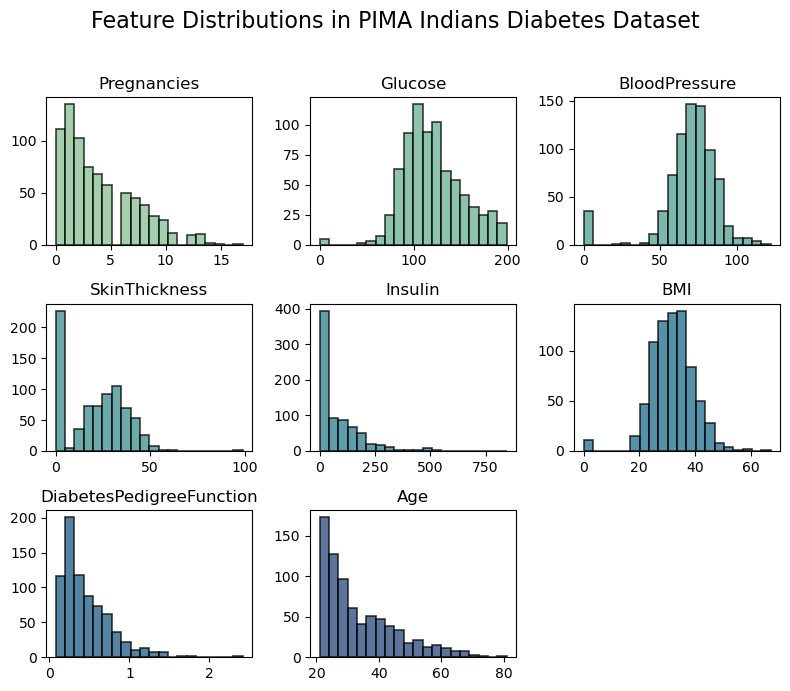

In [23]:
# Set the number of features and extract the 'crest' color palette
num_features = data.drop('Outcome', axis=1).shape[1]
crest_colors = sns.color_palette("crest", num_features)

# Set a larger figure size for the plot grid
plt.figure(figsize=(8, 7))

# Loop through each feature and create histograms with 'crest' colors
for i, column in enumerate(data.drop('Outcome', axis=1).columns):
    plt.subplot(3, 3, i + 1)
    plt.hist(data[column], bins=20, color=crest_colors[i], edgecolor='black', linewidth=1.2, alpha=0.75)
    plt.title(column)

# Customizing the layout and adding a title
plt.suptitle('Feature Distributions in PIMA Indians Diabetes Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make space for the title

# Display the histograms
plt.show()

### **PIE PLOT**

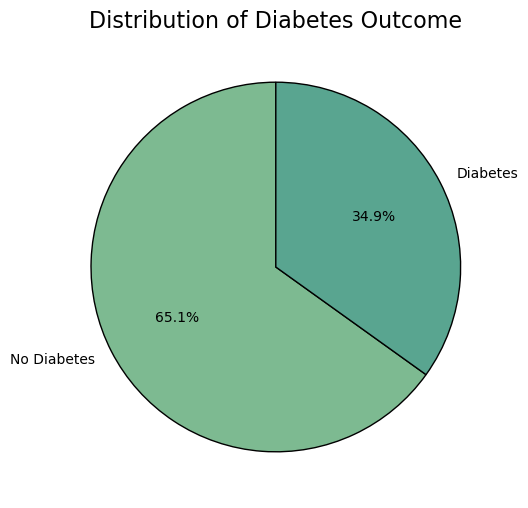

In [24]:
# Count the frequency of each outcome (0 = No Diabetes, 1 = Diabetes)
outcome_counts = data['Outcome'].value_counts()

# Set the color from the "crest" palette for the pie chart
crest_colors = sns.color_palette("crest", as_cmap=False)

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90, colors=crest_colors, wedgeprops={'edgecolor': 'black'})

# Add a title
plt.title('Distribution of Diabetes Outcome', fontsize=16)

# Display the pie chart
plt.show()

### **PAIR PLOT**

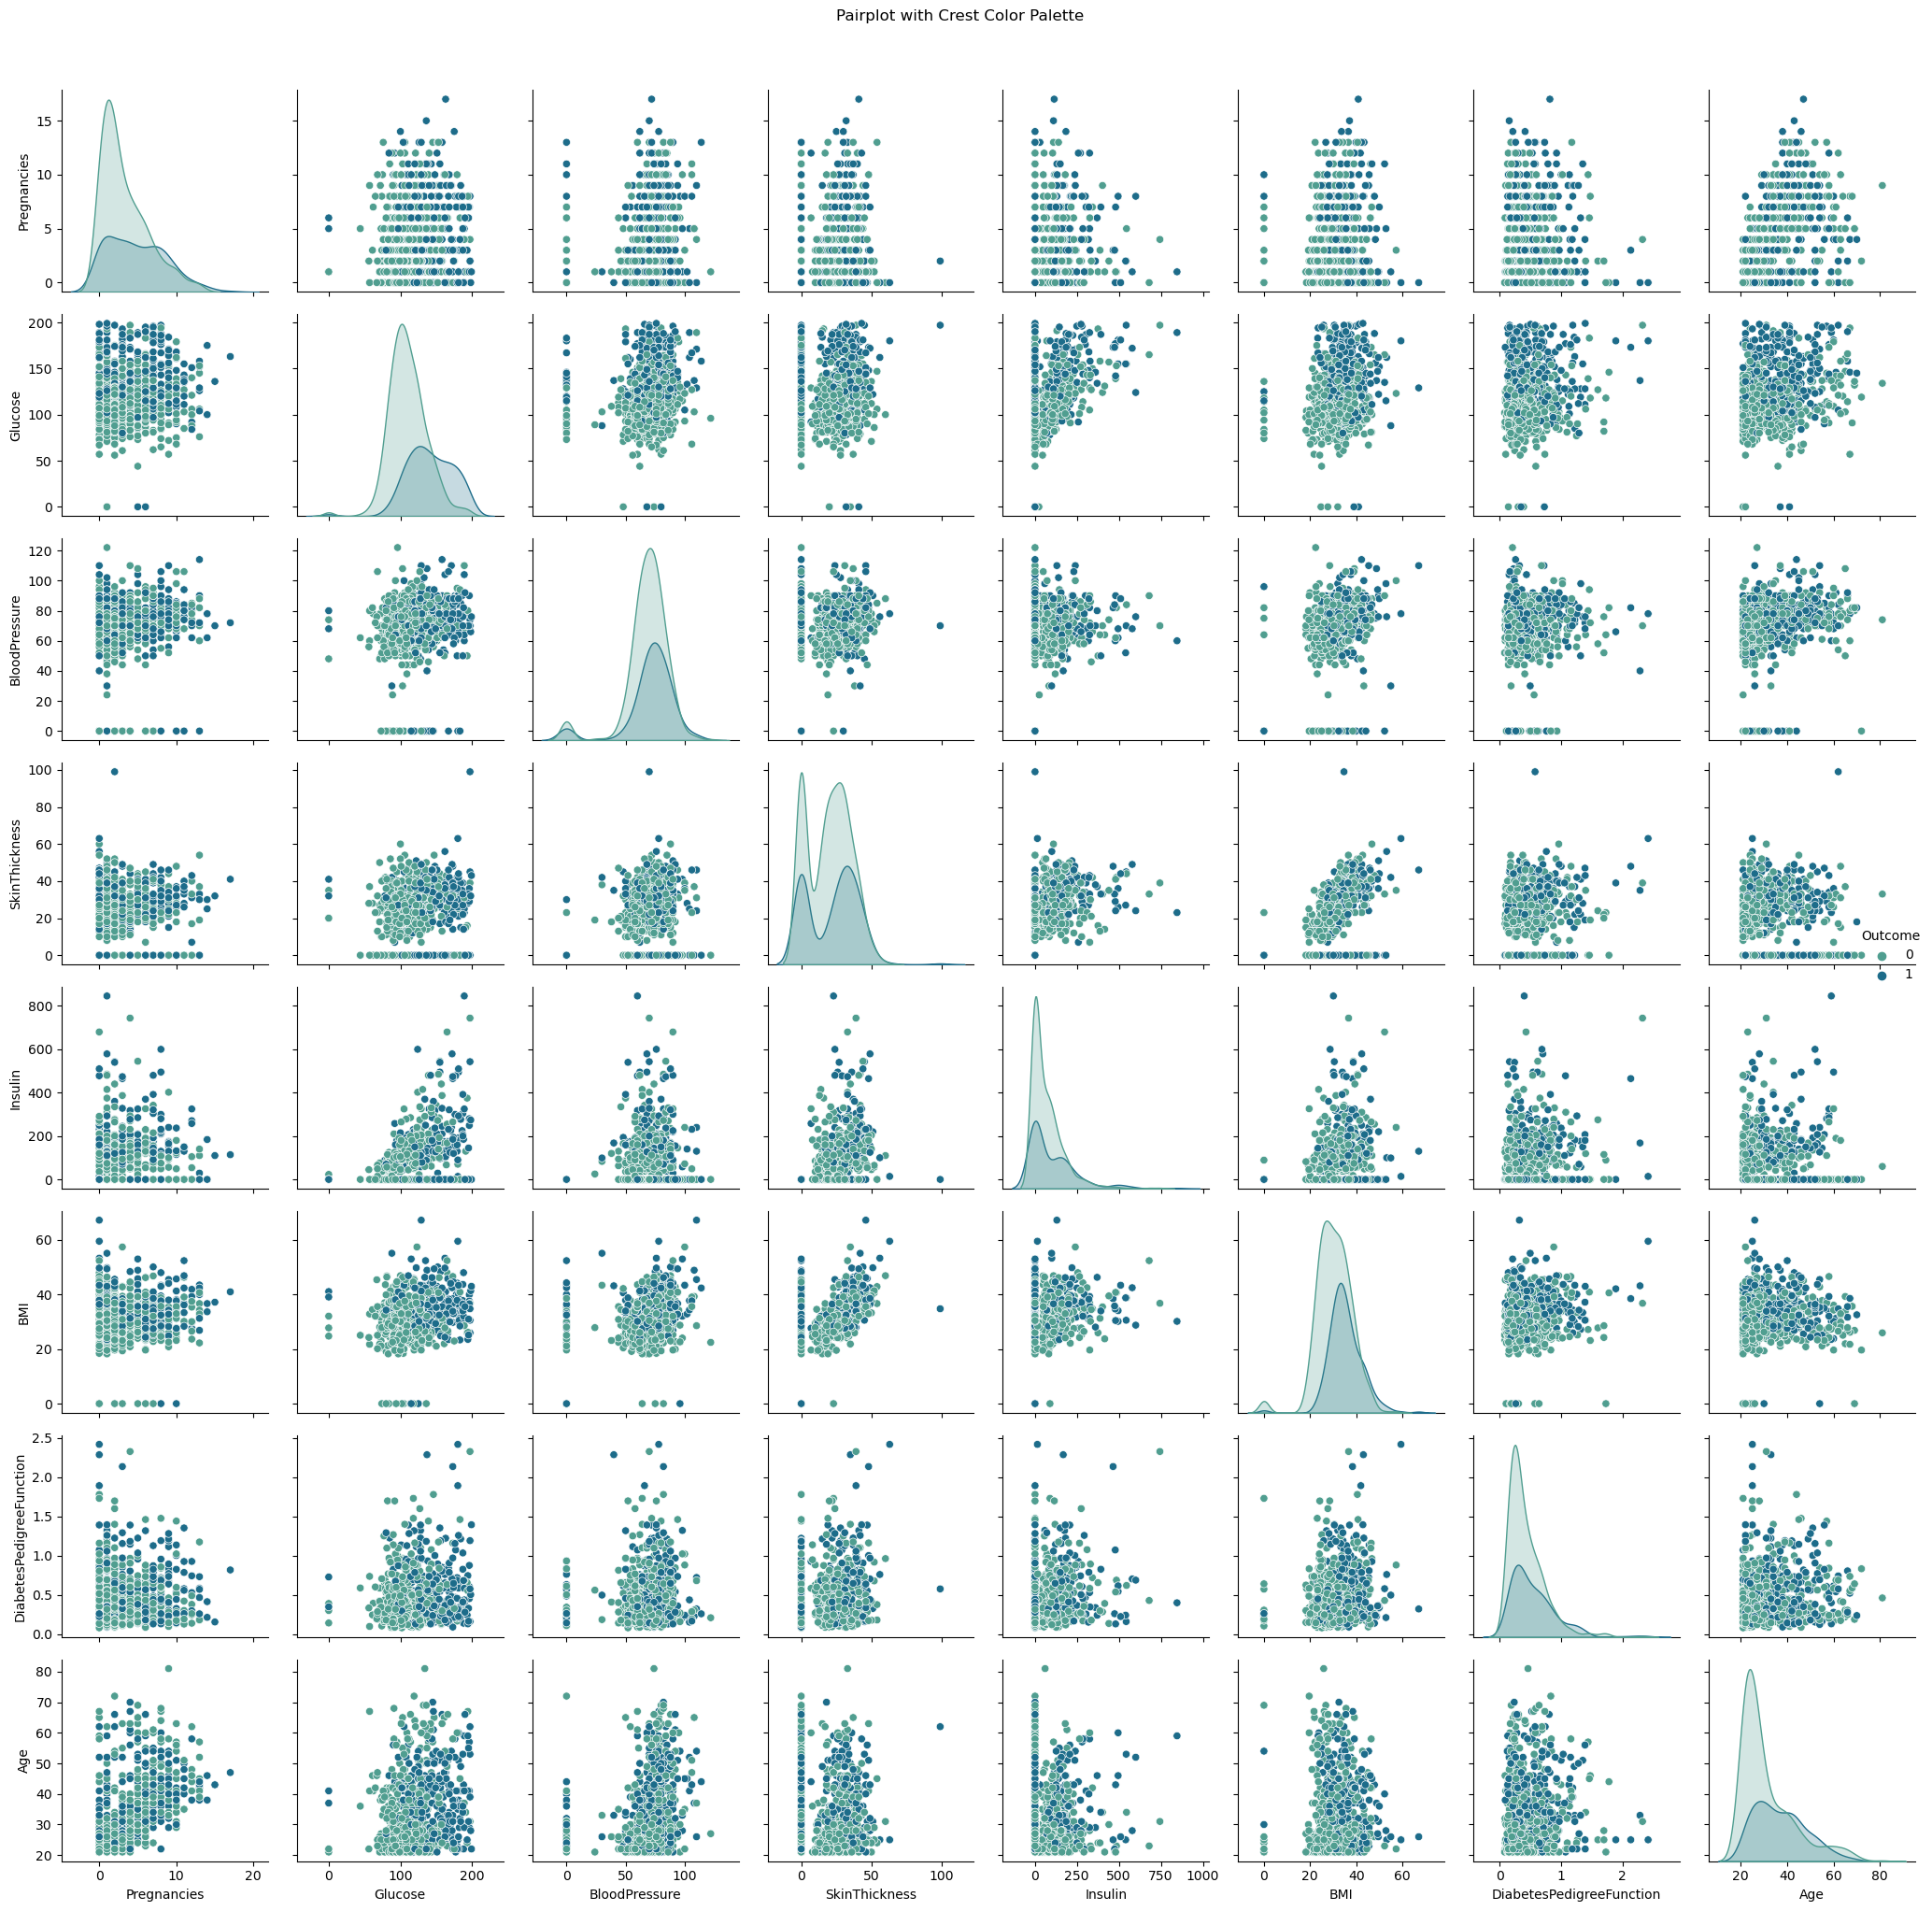

In [25]:
import warnings

# Suppress warnings globally
warnings.filterwarnings('ignore')

# Assuming 'data' is already defined and contains your dataset
p = sns.pairplot(data, hue='Outcome', palette='crest')

# Add title and adjust layout
p.fig.suptitle('Pairplot with Crest Color Palette', y=1.02)
p.fig.tight_layout()

plt.show()


### **CORRELATION HEATMAP**

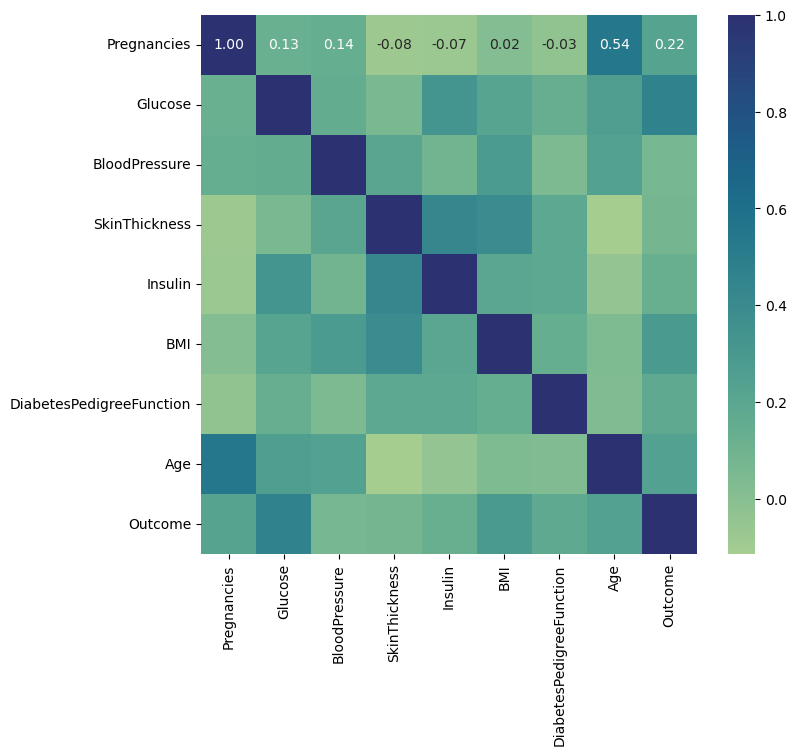

In [26]:
plt.figure(figsize=(8, 7))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(data.corr(), cmap ='crest', annot=True, fmt=".2f")  # seaborn has very simple solution for heatmap

### **BOX PLOT**

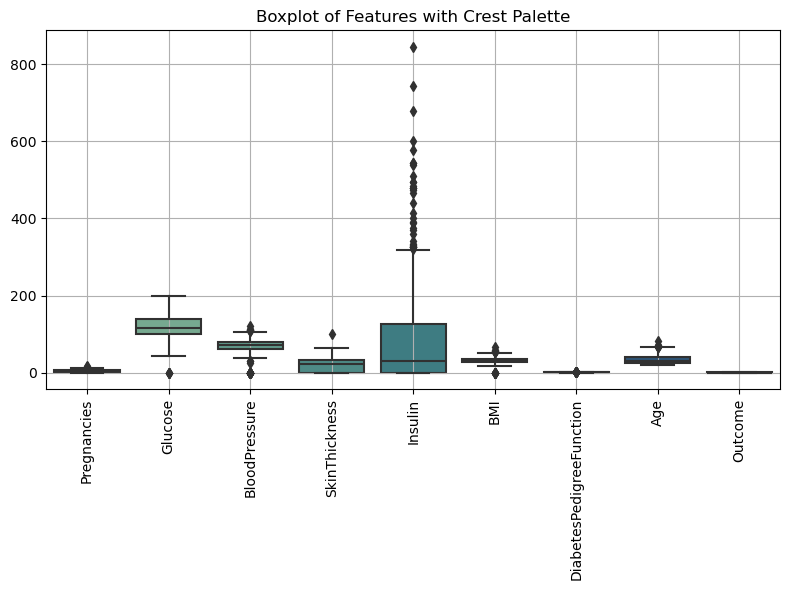

In [27]:
# Plot box plots with the 'crest' palette
plt.figure(figsize=(8, 6))

# Create a single boxplot for all features
sns.boxplot(data=data, palette="crest")
plt.title('Boxplot of Features with Crest Palette')

# Rotate the x-tick labels to avoid overlap
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

## **PREPROCESSING**

In [28]:
from imblearn.pipeline import Pipeline as ImbPipeline

# Replace zero values with NaN for relevant columns
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[
    ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

# Apply SimpleImputer outside the pipeline to handle missing values
imputer = SimpleImputer(strategy='median')
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Fit and transform the data with SimpleImputer
X_imputed = imputer.fit_transform(X)

# Convert the imputed data back to a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Function to detect and cap outliers using IQR method
def cap_outliers(X):
    X = pd.DataFrame(X, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age'])
    for column in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']:
        Q1 = X[column].quantile(0.25)
        Q3 = X[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        X[column] = np.where(X[column] < lower_bound, lower_bound, X[column])
        X[column] = np.where(X[column] > upper_bound, upper_bound, X[column])
    return X

# Apply log transformation for skewed features
def log_transform(X):
    X = pd.DataFrame(X, columns=['Insulin', 'SkinThickness', 'BMI'])
    for column in X.columns:
        X[column] = np.log1p(X[column])
    return X

# Define the preprocessing steps without 'selecting' inside the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('outlier_capping', FunctionTransformer(cap_outliers), ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']),
        ('log_transform', FunctionTransformer(log_transform), ['Insulin', 'SkinThickness', 'BMI']),
        ('poly', PolynomialFeatures(3), ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']),
        ('scaling', StandardScaler(), ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    ]
)

# Define the updated model pipeline with SelectKBest after preprocessor
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Data preprocessing steps
    ('variance_threshold', VarianceThreshold(threshold=0)),
    ('selecting', SelectKBest(f_classif, k=20)),  # Feature selection with SelectKBest after preprocessing
    ('model', StackingClassifier(
        estimators=[
            ('dt', DecisionTreeClassifier(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(),
        n_jobs=-1
    ))
])

# Split the imputed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Apply RandomOverSampler separately
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


## **PREDICTIONS ON DIFFERENT MODELS**

In [29]:
# !pip install lazypredict
import lightgbm as lgb
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate
import re

# Custom logger to suppress LightGBM logs
class DummyLogger:
    def __init__(self):
        pass

    def info(self, msg):
        pass  # Suppress info messages

    def warning(self, msg):
        pass  # Suppress warning messages

# Register the dummy logger to suppress LightGBM logs
lgb.register_logger(DummyLogger())

# Assuming X_train, X_test, y_train, y_test are already defined
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Convert models DataFrame to a tabulated format
models_table = tabulate(models, headers='keys', tablefmt='grid')

# Save the models result to a text file
with open('models_result.txt', 'w') as file:
    file.write(models_table)

# Read the file content
with open('models_result.txt', 'r') as file:
    content = file.read()

# Remove LightGBM-specific logs using regex (in case any slip through)
filtered_content = re.sub(r'\[LightGBM\][^\n]*\n', '', content)

# Save the filtered content into a new file
with open('filtered_models_result.txt', 'w') as file:
    file.write(filtered_content)

# Output the filtered content
print(filtered_content)


100%|██████████| 31/31 [00:01<00:00, 15.60it/s]

+-------------------------------+------------+---------------------+-----------+------------+--------------+
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   Time Taken |
+===============================+============+=====================+===========+============+==============+
| RandomForestClassifier        |   0.753247 |            0.734851 |  0.734851 |   0.754908 |    0.252528  |
+-------------------------------+------------+---------------------+-----------+------------+--------------+
| LGBMClassifier                |   0.74026  |            0.730795 |  0.730795 |   0.743947 |    0.484116  |
+-------------------------------+------------+---------------------+-----------+------------+--------------+
| BaggingClassifier             |   0.757576 |            0.726407 |  0.726407 |   0.756052 |    0.0584714 |
+-------------------------------+------------+---------------------+-----------+------------+--------------+
| XGBClassifier    

## **CROSS-VALIDATION WITH RANDOMIZEDSEARCHCV**

In [30]:
# Define the parameter grid
param_grid = {
    # DecisionTreeClassifier parameters
    'model__dt__max_depth': [10, 20, 30],  # Maximum depth of the decision tree
    'model__dt__min_samples_split': [5, 10],  # Minimum samples required to split a node
    'model__dt__min_samples_leaf': [2, 5],  # Minimum number of samples at a leaf node

    # RandomForestClassifier parameters
    'model__rf__n_estimators': [100, 200],  # Number of trees in the forest
    'model__rf__max_depth': [10, 20],  # Maximum depth of the trees
    'model__rf__min_samples_split': [5, 10],  # Minimum samples required to split a node

    # XGBClassifier parameters
    'model__xgb__n_estimators': [100, 200],  # Number of boosting rounds
    'model__xgb__learning_rate': [0.1, 0.2, 0.3, 0.5],  # Step size shrinkage used in updates to prevent overfitting
    'model__xgb__max_depth': [5, 7],  # Maximum depth of the trees

    # LogisticRegression (final estimator in stacking) parameters
    'model__final_estimator__C': [0.1, 1, 10],  # Inverse regularization strength
    'model__final_estimator__solver': ['lbfgs'],  # Algorithm to use for optimization
    'model__final_estimator__penalty': ['l2'],  # Type of regularization to apply
    'model__final_estimator__max_iter': [100, 150, 200],  # Maximum number of iterations for the solver

    # SelectKBest parameters (feature selection)
    'selecting__k': [10, 20, 30, 40, 50],  # Number of features to select

    # PolynomialFeatures parameters (preprocessing step)
    'preprocessor__poly__degree': [2, 3, 4],  # Degree of the polynomial features to be generated
}


# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10,
                                   scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

# Perform the randomized search on resampled data
random_search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('outlier_capping',
                                                                               FunctionTransformer(func=<function cap_outliers at 0x00000227F2F0AA20>),
                                                                               ['Pregnancies',
                                                                                'Glucose',
                                                                                'BloodPressure',
                                                                                'SkinThickness',
                                                                                'Insulin',
                                                                                'BMI',
                                                                                'Age']),
                                                                              ('log_transform',
                                                                               FunctionTransformer(func=<function log_transform at 0x00000227F51AD58...
                                        'model__final_estimator__solver': ['lbfgs'],
                                        'model__rf__max_depth': [10, 20],
                                        'model__rf__min_samples_split': [5, 10],
                                        'model__rf__n_estimators': [100, 200],
                                        'model__xgb__learning_rate': [0.1, 0.2,
                                                                      0.3,
                                                                      0.5],
                                        'model__xgb__max_depth': [5, 7],
                                        'model__xgb__n_estimators': [100, 200],
                                        'preprocessor__poly__degree': [2, 3, 4],
                                        'selecting__k': [10, 20, 30, 40, 50]},
                   random_state=42, scoring='accuracy')

## **EVALUATION METRICS**

In [31]:
# Get the best parameters and display them
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Make predictions using the best estimator on the test set
y_pred_test = random_search.best_estimator_.predict(X_test)

# Generate and print the classification report for the tuned model on the test set
report_test = classification_report(y_test, y_pred_test)
print("\nClassification Report (Test Set):\n", report_test)

Best Parameters: {'selecting__k': 40, 'preprocessor__poly__degree': 2, 'model__xgb__n_estimators': 200, 'model__xgb__max_depth': 5, 'model__xgb__learning_rate': 0.3, 'model__rf__n_estimators': 100, 'model__rf__min_samples_split': 5, 'model__rf__max_depth': 20, 'model__final_estimator__solver': 'lbfgs', 'model__final_estimator__penalty': 'l2', 'model__final_estimator__max_iter': 100, 'model__final_estimator__C': 0.1, 'model__dt__min_samples_split': 10, 'model__dt__min_samples_leaf': 2, 'model__dt__max_depth': 20}

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       151
           1       0.65      0.72      0.69        80

    accuracy                           0.77       231
   macro avg       0.75      0.76      0.75       231
weighted avg       0.78      0.77      0.77       231

